# Pytorch Linear Regression

In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
np.random.seed(1234)

N = 100
x = np.linspace(0., 1., N)[:,None]
y = x + np.random.normal(0, 0.1, N)[:,None]
plt.plot(x,y, 'ro')
plt.show()

<Figure size 640x480 with 1 Axes>

It: 0, Loss: 1.22e-01
It: 100, Loss: 3.71e-02
It: 200, Loss: 3.03e-02
It: 300, Loss: 2.55e-02
It: 400, Loss: 2.19e-02
It: 500, Loss: 1.90e-02
It: 600, Loss: 1.69e-02
It: 700, Loss: 1.52e-02
It: 800, Loss: 1.40e-02
It: 900, Loss: 1.30e-02
It: 1000, Loss: 1.23e-02
It: 1100, Loss: 1.17e-02
It: 1200, Loss: 1.13e-02
It: 1300, Loss: 1.10e-02
It: 1400, Loss: 1.07e-02
It: 1500, Loss: 1.05e-02
It: 1600, Loss: 1.04e-02
It: 1700, Loss: 1.03e-02
It: 1800, Loss: 1.02e-02
It: 1900, Loss: 1.01e-02
It: 2000, Loss: 1.01e-02
It: 2100, Loss: 1.00e-02
It: 2200, Loss: 1.00e-02
It: 2300, Loss: 9.98e-03
It: 2400, Loss: 9.97e-03
It: 2500, Loss: 9.95e-03
It: 2600, Loss: 9.94e-03
It: 2700, Loss: 9.93e-03
It: 2800, Loss: 9.93e-03
It: 2900, Loss: 9.92e-03
It: 3000, Loss: 9.92e-03
It: 3100, Loss: 9.92e-03
It: 3200, Loss: 9.92e-03
It: 3300, Loss: 9.91e-03
It: 3400, Loss: 9.91e-03
It: 3500, Loss: 9.91e-03
It: 3600, Loss: 9.91e-03
It: 3700, Loss: 9.91e-03
It: 3800, Loss: 9.91e-03
It: 3900, Loss: 9.91e-03
It: 4000, Lo

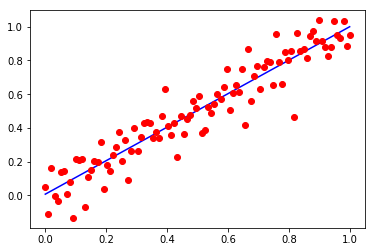

In [2]:
X = torch.from_numpy(x).type(torch.FloatTensor)
Y = torch.from_numpy(y).type(torch.FloatTensor)

class Linear_Layer(torch.nn.Module):
    def __init__(self):
        super(Linear_Layer, self).__init__()
        self.linear = torch.nn.Linear(1, 1) 
        
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred
    
def compute_loss(X, Y):
    Y_pred = FCL(X)
    return torch.mean((Y - Y_pred)**2)

FCL = Linear_Layer()

learning_rate = 0.01
iterations = 5000
optimizer = torch.optim.SGD(FCL.parameters(), lr = learning_rate)

for epochs in range(iterations):
    loss = compute_loss(X, Y)
    # Zero gradients. we need to set the gradients to zero before starting 
    #to do backpropragation because PyTorch accumulates the gradients on 
    #subsequent backward passes 
    optimizer.zero_grad()
    # perform backward pass
    #loss.backward() computes dloss/dx for every parameter
    #x which has requires_grad=True. These are accumulated
    #into x.grad for every parameter x. 
    loss.backward()
    # update weights
    #is performs a parameter update based on the current 
    #gradient (stored in .grad attribute of a parameter)
    #and the update rule.
    optimizer.step()
    if epochs % 100 == 0:
        print('It: %d, Loss: %.2e' % (epochs, loss))
    
Y_pred = FCL(X)
#Covert a cuda float-tensor directly to numpy. First, you
#have to convert it into a cpu float-tensor first, and try converting 
#into numpy, like shown below.
Y_p = Y_pred.cpu().data.numpy()
plt.plot(x, Y_p,'b-')
plt.plot(x, y,'ro')
plt.show()


# Solving a Linear System Using Pytorch


In [4]:
import torch
import torch.utils.data
import torch.nn.functional as F
import timeit
import numpy as np
                
        
class Network(torch.nn.Module):
    def __init__(self, dim1, dim2):
        super(Network, self).__init__()
        self.fc1 = torch.nn.Sequential(
               torch.nn.Linear(dim1, int(dim2/2)), torch.nn.Tanh()) 
        self.fc2 = torch.nn.Sequential(
               torch.nn.Linear(int(dim2/2), dim1), torch.nn.Tanh()) 

    def forward(self, x):
        out = self.fc1(x)
        out = self.fc2(out)
        
        return out 
        
class CNN_ED:
    # Initialize the class
    def __init__(self, X, A, b, nx):  
        # Check if there is a GPU available
        if torch.cuda.is_available() == True:
            self.dtype_double = torch.cuda.FloatTensor
            self.network = Network(64,64).cuda()
        else:
            self.dtype_double = torch.FloatTensor
            self.network = Network(64,64)

        # Define PyTorch dataset
        self.X = torch.from_numpy(X).type(self.dtype_double) 
        self.A = torch.from_numpy(A).type(self.dtype_double)
        self.b = torch.from_numpy(b).type(self.dtype_double)

        # Define the optimizer
        self.optimizer = torch.optim.Adam(list(self.network.parameters()), lr=1e-4)
     
        
    def net(self, X): 
        Z =  self.network(X)  
        return Z 

    def compute_loss(self, X): 
        
        Y_pred = self.net(X)
        Y_pred = Y_pred[-1,:,:].t()
        loss = torch.mean((torch.matmul(self.A, Y_pred) -self.b)**2)
        return loss

  
    # Fetches a mini-batch of data
    def fetch_minibatch(self, X, N_batch):
        N = X.shape[0]
        idx = torch.randperm(N)[0: N_batch]
        X_batch = X[idx,:,:]
        return X_batch
    
    # Trains the model by minimizing the loss
    def train(self, nIter = 10000, batch_size = 512):
        
        start_time = timeit.default_timer()
        for it in range(nIter):
            # Fetch mini-batch
            X_batch = self.fetch_minibatch(self.X, batch_size)
            
            # Reset the optimizer
            self.optimizer.zero_grad()

            # Compute loss
            loss = self.compute_loss(X_batch)
            loss.backward()
            # Train 
            self.optimizer.step()

            # Print
            if it % 100 == 0:
                elapsed = timeit.default_timer() - start_time
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, 
                       loss.cpu().data.numpy(), 
                       elapsed))
                start_time = timeit.default_timer()
  
    
   # Evaluates predictions at test points    
    def predict(self, X_star):
        if torch.cuda.is_available() == True:
            self.dtype_double = torch.cuda.FloatTensor
        else:
            self.dtype_double = torch.FloatTensor

        X_star = torch.from_numpy(X_star).type(self.dtype_double)

        Y_star = self.network(X_star)

        Y_star = Y_star.cpu().data.numpy()

        return Y_star

It: 0, Loss: 3.620e+01, Time: 0.00
It: 100, Loss: 2.761e+00, Time: 0.09
It: 200, Loss: 9.910e-01, Time: 0.09
It: 300, Loss: 4.902e-01, Time: 0.11
It: 400, Loss: 2.925e-01, Time: 0.09
It: 500, Loss: 1.950e-01, Time: 0.09
It: 600, Loss: 1.363e-01, Time: 0.10
It: 700, Loss: 9.881e-02, Time: 0.09
It: 800, Loss: 7.442e-02, Time: 0.09
It: 900, Loss: 5.838e-02, Time: 0.11
It: 1000, Loss: 4.762e-02, Time: 0.09
It: 1100, Loss: 4.022e-02, Time: 0.10
It: 1200, Loss: 3.492e-02, Time: 0.13
It: 1300, Loss: 3.095e-02, Time: 0.18
It: 1400, Loss: 2.782e-02, Time: 0.12
It: 1500, Loss: 2.522e-02, Time: 0.09
It: 1600, Loss: 2.295e-02, Time: 0.09
It: 1700, Loss: 2.091e-02, Time: 0.10
It: 1800, Loss: 1.903e-02, Time: 0.09
It: 1900, Loss: 1.727e-02, Time: 0.10
It: 2000, Loss: 1.563e-02, Time: 0.11
It: 2100, Loss: 1.409e-02, Time: 0.09
It: 2200, Loss: 1.266e-02, Time: 0.10
It: 2300, Loss: 1.132e-02, Time: 0.12
It: 2400, Loss: 1.009e-02, Time: 0.16
It: 2500, Loss: 8.956e-03, Time: 0.18
It: 2600, Loss: 7.923e-0

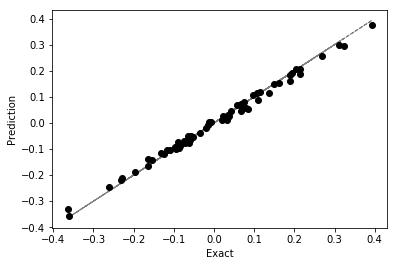

In [5]:
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(1234)
if __name__ == "__main__":
    
    def gen_matrix(N, CondNum = 10.0):
        A = np.random.randn(N,N)
        U,S,V = np.linalg.svd(A)
        S[S!=0] = np.linspace(CondNum,1,N)
        A = np.matmul(U, np.matmul(np.diag(S), V.T))
        return A
    cnd = [50]
    fig444 = plt.figure(444)
    fig444.clf()
    ax444 = fig444.add_subplot(111)

    for cn in cnd:
    # Generate data
        N = 64
        CondNum = cn
        A = gen_matrix(N, CondNum)
        b = np.random.randn(N,1)
        x_star = np.linalg.solve(A,b)
        
        # Define model
        x0 = np.random.randn(1,1,N)
        modelCNN = CNN_ED(x0, A, b, N)

        # Train model
        modelCNN.train(nIter = 8000)

        # Neural network prediction
        x_pred = modelCNN.predict(x0)  
        x_pred = x_pred[:,-1].T
        # Print error
        error = np.linalg.norm(x_star - x_pred, 2)/np.linalg.norm(x_star, 2)
        print('Relative error: %e' % (error))
        
        # Plot
        ax444.plot(x_star, x_star, 'k--', linewidth = 1, alpha = 0.5)
        ax444.plot(x_star, x_pred, 'ko')
        ax444.set_xlabel('Exact')
        ax444.set_ylabel('Prediction')
        